In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from chatty.utils import dd_encodings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import textblob
import gensim
import spacy
import os

import data
import plot

from chatty.utils import cleaning

Takes a 5 minutes the first time, but use `use_cached` afterward so you don't have to wait in the future.

In [3]:
train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)

Using Cached


In [4]:
# LAG_MASK = ['act', 'emo', 'polarity', 'subjectivity']
# train_lags = data.get_lags(train[LAG_MASK], lag_range=[1, 2])

In [5]:
train['utter_t-1'] = data.get_lags(train[['utter']], lag_range=[1])

### Classify Dialogue Acts

### First shot Random forest, word vectors, handful of others (need to include POS stuff)

### First shot with RandomForest

In [5]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [9]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.49028102 0.13095635 0.34832833 0.0304343 ]
 [0.13614522 0.50461445 0.21951033 0.13973   ]
 [0.16993794 0.11067662 0.69890005 0.02048539]
 [0.02261995 0.10124669 0.0444371  0.83169626]]


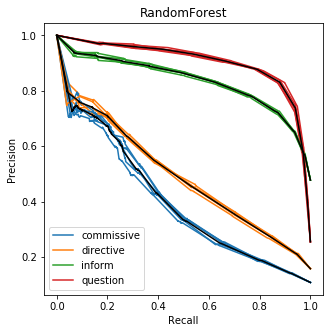

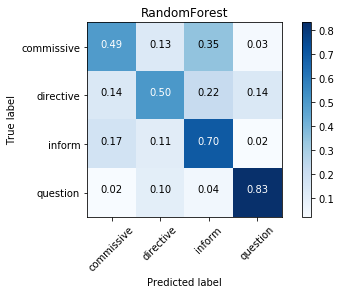

In [10]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### Second Shot no word vectors

In [22]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
X = train[TRAIN_MASK].values[ACT_MASK]
y = train['act'][ACT_MASK]

In [27]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.45784738 0.15583694 0.3497723  0.03654337]
 [0.16650141 0.28556174 0.27419724 0.27373961]
 [0.26918613 0.1610828  0.55297946 0.0167516 ]
 [0.01700038 0.07333774 0.01374197 0.89591991]]


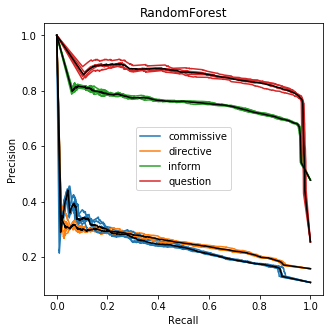

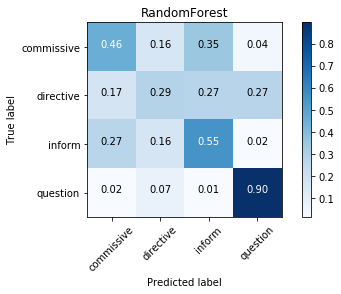

In [28]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

It looks like this classfier is really good at pointing out if something is a question or not. This could be used as a first line.

### Word vectors, Features, No Questions

In [55]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull() & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [56]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.48750417 0.14650672 0.36598911]
 [0.12950957 0.64289528 0.22759515]
 [0.16448862 0.11874968 0.71676169]]


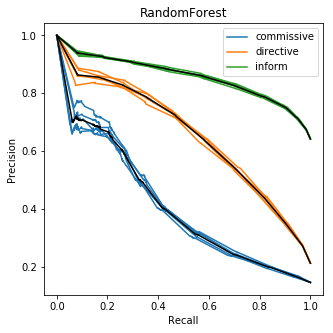

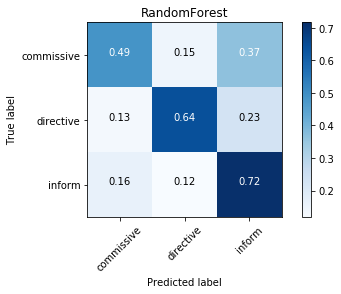

In [57]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### Features, No Word vectors,  No Questions

In [58]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull() & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
X = train[TRAIN_MASK].values[ACT_MASK]
y = train['act'][ACT_MASK]

In [59]:
results = data.cv_stratified_shuffle(X, y,
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


Normalized confusion matrix
[[0.46273464 0.18005109 0.35721426]
 [0.18030661 0.53161467 0.28807871]
 [0.27115394 0.17447904 0.55436702]]


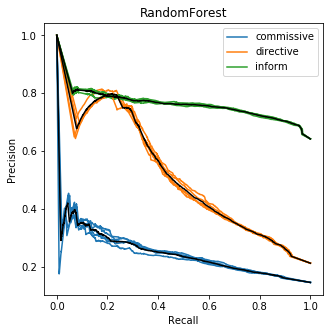

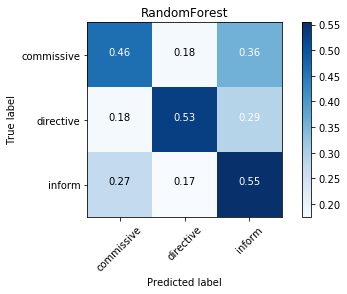

In [60]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

### POS, Lemma, Tagging

In [830]:
import nltk
import spacy
from functools import partial
nlp = spacy.load('en')
nlp.disable_pipes('ner')


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TransformerMixin
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import string


punctuations = string.punctuation


def filter_punct(word: spacy.tokens.token.Token) -> bool:
    return not word.is_punct


def filter_stop(word: spacy.tokens.token.Token) -> bool:
    return not word.is_stop


def lemmatize(word: spacy.tokens.token.Token) -> str:
    return word.lemma_


def part_of_speech(word: spacy.tokens.token.Token) -> str:
    return word.pos_


def tag(word: spacy.tokens.token.Token) -> str:
    return word.tag_


def dep(word: spacy.tokens.token.Token) -> str:
    return word.dep_


def original_word(word: spacy.tokens.token.Token) -> str:
    return word.text


def include_conditional_word(word: spacy.tokens.token.Token, word_list=[]) -> bool:
    if word.text.lower() in word_list:
        return word.text
    return ''


def join_ngrams(parsed_sentence: list, ngrams=[1], sep='|') -> list:
    for size in ngrams:
        for gram in nltk.ngrams(parsed_sentence, size):
            yield sep.join(gram)


# def spacy_tokenizer(sentence: str,
def spacy_tokenizer(spacy_toks,
                    functions=[(original_word, 'original_word')],
                    filters=[],
                    include=[],
                    ngrams=[1],
                    prefix=''):
#     sentence = sentence.strip()
#     spacy_toks = nlp(sentence, disable=['sentiment', 'word2vec', 'tensor'])
    tokens = []
    for tok in spacy_toks:
        includes = [f(tok) for f in include]
        if all([f(tok) for f in filters]) or any(includes):
            tags = [] + includes
            for f, f_name in functions:
                tags.append(f_name + '_' + f(tok))
            tokens.append(prefix + '_'.join(tags))
    joined = join_ngrams(tokens, ngrams=ngrams)
    return joined

In [106]:
from sklearn.naive_bayes import BernoulliNB

part_of_speech_grams = partial(spacy_tokenizer,
                               functions=[(part_of_speech, 'POS')],
                               filters=[filter_stop, filter_punct],
                               include=[partial(include_conditional_word, word_list=['?'])],
                               ngrams=[1, 2])

# part_of_speech_grams_t_minus_1 = partial(spacy_tokenizer,
#                                          functions=[(lemmatize, 'lemma')],
#                                          filters=[filter_stop, filter_punct],
#                                          include=[partial(include_conditional_word, word_list=['?'])],
#                                          ngrams=[1])

In [213]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull() & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
# X = train[TRAIN_MASK].values[ACT_MASK]
utterances = train['utter'][ACT_MASK].values
utterances_t_minus_1 = train['utter_t-1'][ACT_MASK].values
y = train['act'][ACT_MASK]

##### Random Forest

In [215]:
clf = Pipeline([
    ('countvec', CountVectorizer(analyzer=part_of_speech_grams)),
    ('RandomForest', RandomForestClassifier(n_jobs=-1))
])

results = data.cv_stratified_shuffle(utterances[::35], y[::35],
                                     clf,
#                                      RandomForestClassifier(n_jobs=-1),
                                     splits=2,
                                     upsample=None)

Training
Training


Normalized confusion matrix
[[0.1509434  0.08679245 0.76226415]
 [0.05181347 0.4119171  0.53626943]
 [0.04847397 0.05116697 0.90035907]]


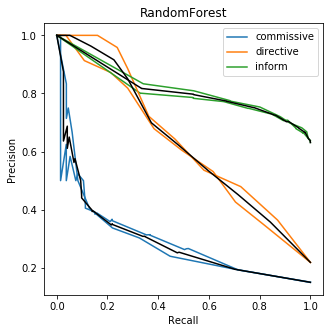

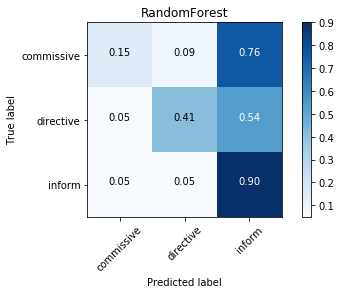

In [216]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title);

In [217]:
one = results['models'][0]

model = one.steps[1][1]

vec = one.steps[0][1]

features = list(sorted(zip(model.feature_importances_, vec.get_feature_names()), reverse=True))

In [371]:
features[:100]

[(0.03263654778338038, '?_lemma_?'),
 (0.013892190792408656, '_lemma_.'),
 (0.0129365776836269, '_POS_NOUN|?_POS_PUNCT'),
 (0.008610021265353183, '_lemma_do|_lemma_-PRON-'),
 (0.0072411268273783426, '_lemma_what'),
 (0.00684087694851631, '_lemma_-PRON-|?_lemma_?'),
 (0.006106909383960715, '(T-1)_?_lemma_?'),
 (0.005426377324379594, 'DEP_aux|DEP_nsubj'),
 (0.005019119561661971, '_POS_VERB|?_POS_PUNCT'),
 (0.004352482137510686, '_POS_PRON|_POS_VERB|?_POS_PUNCT'),
 (0.003961331780660124, '_POS_PRON|?_POS_PUNCT'),
 (0.0037012244793641555, '_POS_ADV|?_POS_PUNCT'),
 (0.003527566312045062, '_POS_ADP|_POS_DET'),
 (0.003441642601242633, '(T-1)__lemma_to'),
 (0.0031214005079513536, '_lemma_-PRON-'),
 (0.003031944017421983, '_lemma_ok'),
 (0.0028054472726514517, '_POS_ADJ|_POS_NOUN|?_POS_PUNCT'),
 (0.002686276194513692, 'DEP_dobj|DEP_punct'),
 (0.002607713741359349, '(T-1)__lemma_will'),
 (0.0026065642728825026, '_POS_VERB|_POS_PRON'),
 (0.0026043861673063456, '(T-1)__lemma_-PRON-'),
 (0.00256054

##### RandomForest again  but including previous utterance

In [831]:
part_of_speech_grams = partial(spacy_tokenizer,
                               functions=[(part_of_speech, 'POS')],
                               filters=[filter_punct],
                               include=[partial(include_conditional_word, word_list=['?'])],
                               ngrams=[2, 3])

part_of_speech_grams_t_minus_1 = partial(part_of_speech_grams, prefix='(T-1)_')

lemmatizer_grams = partial(spacy_tokenizer,
                           functions=[(lemmatize, 'lemma')],
                           filters=[],
                           include=[partial(include_conditional_word, word_list=['?'])],
                           ngrams=[1, 2, 3])

lemmatizer_grams_t_minus_1 = partial(lemmatizer_grams, prefix='(T-1)_')

dep_grams = partial(spacy_tokenizer,
                    functions=[(dep, 'DEP')],
                    filters=[],
                    include=[],
                    ngrams=[2])


def biturn_analyzer(string: str) -> list:
    sentence = string.strip()
    current_string, prev_string = string.split("__eou__")
    current_string = nlp(current_string, disable=['sentiment', 'word2vec', 'tensor'])
    prev_string = nlp(prev_string, disable=['sentiment', 'word2vec', 'tensor'])

    current_grams = part_of_speech_grams(current_string)
    prev_grams = part_of_speech_grams_t_minus_1(prev_string)
    current_grams_lemma = lemmatizer_grams(current_string)
    prev_grams_lemma = lemmatizer_grams_t_minus_1(prev_string)
    current_grams_dep = dep_grams(current_string)
    for gen in (current_grams, prev_grams, current_grams_lemma, prev_grams_lemma, current_grams_dep):
        for i in gen:
            yield i

In [13]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()# & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

# TRAIN_MASK = ['first_utterance',
#               'subjectivity',
#               'utter_len',
#               'has_question_mark',
#               'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
# X = train[TRAIN_MASK].values[ACT_MASK]
utterances = train['utter'][ACT_MASK].values
utterances_t_minus_1 = train['utter_t-1'][ACT_MASK].values
utterances = np.array(['__eou__'.join(i) for i in zip(utterances, utterances_t_minus_1)])
y = train['act'][ACT_MASK].values

In [14]:
clf = Pipeline([
    ('countvec', CountVectorizer(analyzer=biturn_analyzer)),
    ('RandomForest', RandomForestClassifier(n_jobs=-1, verbose=True))
])


results = data.cv_stratified_shuffle(utterances[::35], y[::35],
                                     clf,
                                     splits=2,
                                     upsample='random')

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:53: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:53: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s 

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:53: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:53: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Normalized confusion matrix
[[0.1259542  0.01526718 0.85114504 0.00763359]
 [0.02887139 0.10498688 0.64566929 0.22047244]
 [0.02206531 0.01588703 0.94792586 0.0141218 ]
 [0.01010101 0.02525253 0.23063973 0.73400673]]


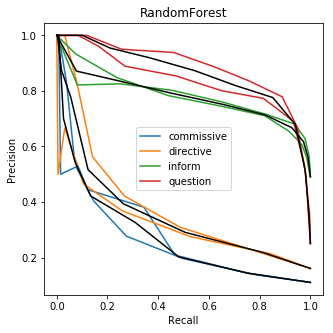

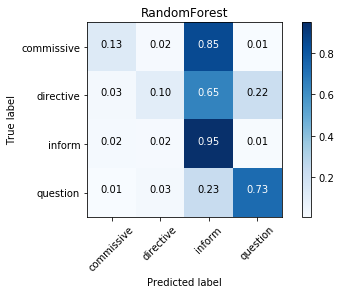

In [96]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title, save_name='Test');

In [27]:
one = results['models'][0]
model = one.steps[1][1]
vec = one.steps[0][1]
features = list(sorted(zip(model.feature_importances_, vec.get_feature_names()), reverse=True))
features

[(0.03263654778338038, '?_lemma_?'),
 (0.013892190792408656, '_lemma_.'),
 (0.0129365776836269, '_POS_NOUN|?_POS_PUNCT'),
 (0.008610021265353183, '_lemma_do|_lemma_-PRON-'),
 (0.0072411268273783426, '_lemma_what'),
 (0.00684087694851631, '_lemma_-PRON-|?_lemma_?'),
 (0.006106909383960715, '(T-1)_?_lemma_?'),
 (0.005426377324379594, 'DEP_aux|DEP_nsubj'),
 (0.005019119561661971, '_POS_VERB|?_POS_PUNCT'),
 (0.004352482137510686, '_POS_PRON|_POS_VERB|?_POS_PUNCT'),
 (0.003961331780660124, '_POS_PRON|?_POS_PUNCT'),
 (0.0037012244793641555, '_POS_ADV|?_POS_PUNCT'),
 (0.003527566312045062, '_POS_ADP|_POS_DET'),
 (0.003441642601242633, '(T-1)__lemma_to'),
 (0.0031214005079513536, '_lemma_-PRON-'),
 (0.003031944017421983, '_lemma_ok'),
 (0.0028054472726514517, '_POS_ADJ|_POS_NOUN|?_POS_PUNCT'),
 (0.002686276194513692, 'DEP_dobj|DEP_punct'),
 (0.002607713741359349, '(T-1)__lemma_will'),
 (0.0026065642728825026, '_POS_VERB|_POS_PRON'),
 (0.0026043861673063456, '(T-1)__lemma_-PRON-'),
 (0.00256054

In [91]:
df = pd.DataFrame(np.concatenate([np.concatenate(results['y_proba']),
                                  np.concatenate(results['y_true']).reshape(-1, 1),
                                  utterances[::35].reshape(-1, 1)],
                                  axis=1),
                  columns=list(results['classes']) + ['y_true'] + ['utterances'])

In [138]:
missed = df[(df['y_true'] == 'directive') & (df['inform'] > .9)]
missed

,commissive,directive,inform,question,y_true,utterances
89,0,0,1,0,directive,"Well , you can't blame them . It's a confusin..."
226,0,0,1,0,directive,Certainty.Do you want double breasted suit or...
403,0,0,1,0,directive,I asked a few people who are already living i...
960,0,0,1,0,directive,It must be really painful . I remember when J...
999,0,0,1,0,directive,I still have five seats in the mezzanine . __...
1022,0,0,1,0,directive,Fine . Thank you . __eou__ Not bad . How abou...
1624,0,0,1,0,directive,Would you like to see a movie with me and my ...
2099,0,0,1,0,directive,Could you tell something about the job ? __eo...


In [142]:
not_missed = df[(df['y_true'] == 'directive') \
                & (df['directive'] > df['inform']) \
                & (df['directive'] > df['question'])\
                & (df['directive'] > df['commissive'])]

not_missed

,commissive,directive,inform,question,y_true,utterances
42,0.2,0.6,0.2,0,directive,Do you have anything which can prevent wrinkl...
100,0,0.6,0.2,0.2,directive,"Yes , would you please tell her Eric Martin c..."
114,0.1,0.5,0.2,0.2,directive,"Yes , sir . It's one of the best beers in Chi..."
143,0,0.6,0.2,0.2,directive,"They are By new models now , they are not ver..."
196,0,0.5,0.3,0.2,directive,You see . I've lost my weight in spite of my ...
239,0.3,0.5,0.1,0.1,directive,Then you got a windfall ! Was sixty-five the ...
326,0,0.6,0.4,0,directive,"I am ready I am going to get , let's start ! ..."
366,0,0.9,0.1,0,directive,"I always love skiing . You know , it's a cool..."
601,0,0.4,0.3,0.3,directive,what about the chicken ? __eou__ yes . Once i...
725,0.2,0.4,0.2,0.2,directive,"Oh , that means I can do whatever I like with..."


In [123]:
from spacy import displacy

def render(utterance, style='dep'):
    displacy.render(nlp(utterance), style=style, jupyter=True, options={'distance':90})

In [154]:
not_missed['second'] = not_missed['utterances'].str.split('__eou__').map(lambda x: nlp(x[0]))
not_missed['first'] = not_missed['utterances'].str.split('__eou__').map(lambda x: nlp(x[1]))

missed['second'] = missed['utterances'].str.split('__eou__').map(lambda x: nlp(x[0]))
missed['first'] = missed['utterances'].str.split('__eou__').map(lambda x: nlp(x[1]))

/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

### Try model including dependency tree

In [680]:
type(next(nlp(utterances[0].split('__eou__')[0]).sents))

spacy.tokens.span.Span

In [912]:
def point_of_view_action(sent: spacy.tokens.span.Span, prefix='') -> str:
    seen_nsubj = False
    seen_question = any([i.text == '?' for i in sent])
    seen_affirm = any([i.text.lower() in {'yes', 'affirmative'} for i in sent])
    if not seen_nsubj and seen_affirm:
        return prefix + "2ND_PERSON" + '_' + 'AFFIRM' + '_' + sent.root.pos_
    if sent.root.pos_ == "VERB":
        for child in sent.root.children:
            if child.dep_ == "nsubj":
                seen_nsubj = True
                text = child.text.lower()
                if text in {"you"}:
                    tag = "2ND_PERSON"
                elif text in {"me", "i", "we"}:
                    tag = "1ST_PERSON"
                else:
                    tag = "3RD_PERSON"
                if seen_question:
                    return prefix + tag + '_' + 'QUESTION' + '_' + sent.root.pos_ 
                return prefix + tag + '_' + sent.root.pos_
        if not seen_nsubj and not seen_affirm:
            if seen_question:
                return prefix + "2ND_PERSON" + '_' + "QUESTION" + '_' + sent.root.pos_
            else:
                return prefix + "2ND_PERSON" + '_' + 'COMMAND' + '_' + sent.root.pos_
        elif not seen_nsubj and seen_affirm:
            return prefix + "2ND_PERSON" + '_' + 'AFFIRM' + '_' + sent.root.pos_
    return ""

def point_of_view_action_doc(doc: spacy.tokens.doc.Doc, prefix='') -> str:
    toks = []
    for sent in doc.sents:
        tok = point_of_view_action(sent, prefix=prefix)
        toks.append(tok)
    joined = join_ngrams(toks)
    return joined
#     return toks

In [914]:
part_of_speech_grams = partial(spacy_tokenizer,
                               functions=[(part_of_speech, 'POS')],
                               filters=[filter_punct],
                               include=[partial(include_conditional_word, word_list=['?'])],
                               ngrams=[2, 3])

part_of_speech_grams_t_minus_1 = partial(part_of_speech_grams, prefix='(T-1)_')

lemmatizer_grams = partial(spacy_tokenizer,
                           functions=[(lemmatize, 'lemma')],
                           filters=[],
                           include=[partial(include_conditional_word, word_list=['?'])],
                           ngrams=[2, 3])

lemmatizer_grams_t_minus_1 = partial(lemmatizer_grams, prefix='(T-1)_')

dep_grams = partial(spacy_tokenizer,
                    functions=[(dep, 'DEP')],
                    filters=[],
                    include=[],
                    ngrams=[2])


def biturn_analyzer(string: str) -> list:
    sentence = string.strip()
    current_string, prev_string = sentence.split("__eou__")
    current_string = nlp(current_string, disable=['sentiment', 'word2vec', 'tensor'])
    prev_string = nlp(prev_string, disable=['sentiment', 'word2vec', 'tensor'])
    
    current_grams = part_of_speech_grams(current_string)
    current_grams_lemma = lemmatizer_grams(current_string)
    current_pov_act = point_of_view_action_doc(current_string)
    prev_pov_act = point_of_view_action_doc(prev_string, prefix="(T-1)_")

    for gen in (current_grams, current_grams_lemma, current_pov_act, prev_pov_act):
        for i in gen:
            if i:
                yield i

In [917]:
doc = "Yes Sir. __eou__ Please go to the store. When you are done, go home"
list(biturn_analyzer(doc))

['_POS_INTJ|_POS_PROPN',
 '_lemma_yes|_lemma_sir',
 '_lemma_sir|_lemma_.',
 '_lemma_yes|_lemma_sir|_lemma_.',
 '2ND_PERSON_AFFIRM_INTJ',
 '(T-1)_2ND_PERSON_COMMAND_VERB',
 '(T-1)_2ND_PERSON_COMMAND_VERB']

In [916]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()# & train['act'].isin(['directive', 'commissive', 'inform'])

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

# TRAIN_MASK = ['first_utterance',
#               'subjectivity',
#               'utter_len',
#               'has_question_mark',
#               'has_question_mark_t-1']

# X = np.concatenate((train_vecs,
#                     train[TRAIN_MASK].values),
#                    axis=1)[ACT_MASK]
# X = train[TRAIN_MASK].values[ACT_MASK]
utterances = train['utter'][ACT_MASK].values
utterances_t_minus_1 = train['utter_t-1'][ACT_MASK].values
utterances = np.array(['__eou__'.join(i) for i in zip(utterances, utterances_t_minus_1)])
y = train['act'][ACT_MASK].values

In [920]:
utterances[::50].shape

(1659,)

In [921]:
clf = Pipeline([
    ('countvec', CountVectorizer(analyzer=biturn_analyzer)),
    ('RandomForest', RandomForestClassifier(n_jobs=-1, verbose=True))
])


results = data.cv_stratified_shuffle(utterances[::50], y[::50],
                                     clf,
                                     splits=2,
                                     upsample='random')

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:54: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:54: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s 

Training


/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:54: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
/Users/ryan/miniconda3/envs/chatty/lib/python3.6/site-packages/ipykernel/__main__.py:54: DeprecationWarning: generator 'ngrams' raised StopIteration
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Normalized confusion matrix
[[0.16756757 0.02162162 0.77297297 0.03783784]
 [0.02973978 0.08178439 0.63568773 0.2527881 ]
 [0.04968153 0.01401274 0.9133758  0.02292994]
 [0.00952381 0.01666667 0.15952381 0.81428571]]


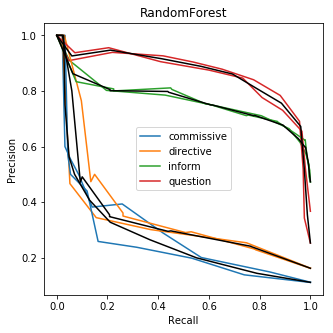

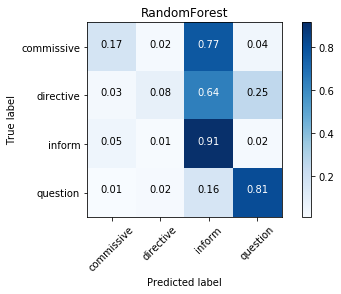

In [922]:
title = "RandomForest"
plot.plot_prec_rec(results, title)
le = LabelEncoder()
le.fit(results['classes'])
cm = confusion_matrix(le.transform(np.concatenate(results['y_true'])),
                      np.argmax(np.concatenate(results['y_proba']), axis=1))
plt.figure()
plot.plot_confusion_matrix(cm, le.classes_, normalize=True, title=title, save_name='Test');

In [923]:
one = results['models'][0]
model = one.steps[1][1]
vec = one.steps[0][1]
features = list(sorted(zip(model.feature_importances_, vec.get_feature_names()), reverse=True))
features

[(0.02644350057533702, '2ND_PERSON_QUESTION_VERB'),
 (0.016197509663708153, '3RD_PERSON_QUESTION_VERB'),
 (0.014111053860624598, '_lemma_do|_lemma_-PRON-'),
 (0.012951301721076166, '_POS_NOUN|?_POS_PUNCT'),
 (0.008753360078910834, '(T-1)_3RD_PERSON_QUESTION_VERB'),
 (0.008292613880084012, '_POS_ADV|?_POS_PUNCT'),
 (0.007825522717264792, '_POS_VERB|_POS_PRON|_POS_VERB'),
 (0.0059598754195086005, '_POS_VERB|?_POS_PUNCT'),
 (0.005826497955213599, '_POS_PRON|?_POS_PUNCT'),
 (0.005759376148121069, '(T-1)_1ST_PERSON_VERB'),
 (0.005348984282127697, '3RD_PERSON_VERB'),
 (0.00530029568187588, '_lemma_-PRON-|_lemma_will'),
 (0.005217420310802547, '(T-1)_2ND_PERSON_COMMAND_VERB'),
 (0.004694592455790016, '1ST_PERSON_VERB'),
 (0.004564554680455536, '1ST_PERSON_QUESTION_VERB'),
 (0.004358705502549409, '_POS_PRON|_POS_VERB'),
 (0.0043478254725136745, '_POS_NOUN|_POS_VERB|_POS_PRON'),
 (0.00430587810797428, '_POS_DET|_POS_NOUN|?_POS_PUNCT'),
 (0.0038605799671816545, '_lemma_.|_lemma_do'),
 (0.0038528

### Question marks are very important!

In [14]:
model = results['models'][0]

In [15]:
features = sorted(zip(model.feature_importances_, [str(i) for i in range(300)] + TRAIN_MASK), key=lambda x: x[0], reverse=True)

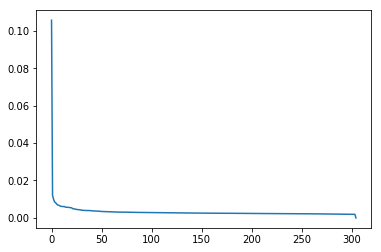

In [16]:
plt.plot(list(zip(*features))[0])

Commissive and Directives are being confused with inform. 

Given the strength of the question mark. 

I think our word vectors are doing very little to help us here. 

I think it's time to introduce some parts of speech tags along with n-grams to capture the use of commissive words and an "I" before them. 

### 20 and 21 are duplicates

In [17]:
def class_dist(col, df):
    nums = []
    for i in np.arange(0, 1, .1):
        nums.append(df[df[col] > i].shape[0] / df.shape[0])
    plt.plot(np.arange(0, 1, .1), nums, label=col)
    plt.legend()

def plot_confusion_contour(df):
    for cls in results['classes']:
        class_dist(cls, df)

def make_proba_df(results):
    y_proba = pd.DataFrame(np.concatenate(results['y_proba']))
    y_true = pd.concat(results['y_true'])
    y_proba.index = y_true.index
    y_proba.columns = results['classes']
    return y_proba

df = train.join(make_proba_df(results))

df = df[['utter', 'act'] + list(results['classes'])]

In [18]:
commissive = df[(df['act'] == 'commissive')]
commissive = commissive.sort_values('commissive', ascending=True)

In [19]:
num = 100
commissive.iloc[num]['utter']

' See you soon ! Bye ! Egg ... I can ’ t stand that woman or her obnoxious daughter . '

In [20]:
commissive.iloc[num]

utter          See you soon ! Bye ! Egg ... I can ’ t stand ...
act                                                  commissive
commissive                                                    0
directive                                                   0.1
inform                                                      0.7
question                                                    0.2
Name: (7634, 12), dtype: object

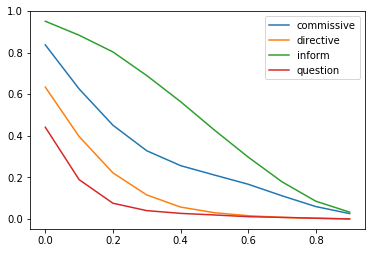

In [21]:
plot_confusion_contour(commissive)